In [1]:
import cv2 
import matplotlib.pyplot as plt
import os
from sys import exit
from cv2 import *#xfeatures2d
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from skimage.measure import ransac
from skimage.transform import AffineTransform, warp
from scipy.ndimage import affine_transform
import glob
from mpl_toolkits import mplot3d
#%matplotlib widget

In [67]:
# Copute SIFT matches
img1 = cv2.imread('lxtek1.jpg',0)  #queryimage # left image
img2 = cv2.imread('lxtek2.jpg',0) #trainimage # right image
sift = cv2.SIFT_create()
#sift = cv2.KAZE_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 20)
search_params = dict(checks=100)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2) 
    
# extract points
good=[]
pts1 = []
pts2 = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.30*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
print(len(good), ' Matches') 

73  Matches


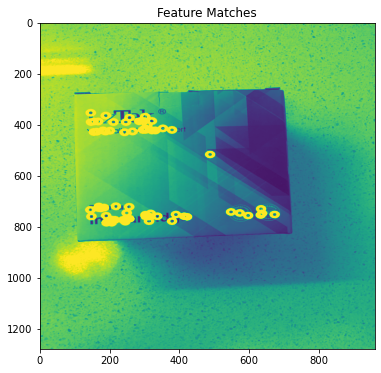

In [3]:
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good[:], img2)#,5)# flags=2)
for pts in pts1:
    img3 = cv2.circle(img1,tuple((int(pts[0]),int(pts[1]))),10,(255,0,0),10)
plt.figure(figsize=((6), (6)))
plt.title('Feature Matches')
plt.imshow(img3,aspect='auto')
plt.savefig('lxtek_matches.png',dpi=1000)
plt.show()
plt.close()

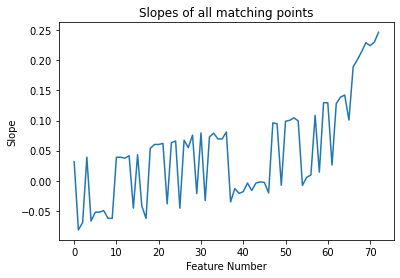

In [97]:
# Get Slopes of lines joining two images: we can use this to find outliers: they should all have a similar slope
pns1=np.int32(pts1)
pns2=np.int32(pts2)
m=[]
for i in range(len(pns2)):
    pns2[i][0] = pns2[i][0] + img1.shape[1]
    m.append(-(pns2[i][1] - pns1[i][1]) / (pns2[i][0] - pns1[i][0]))
m=np.array(m)
plt.plot(m)
plt.title('Slopes of all matching points')
plt.ylabel('Slope')
plt.xlabel('Feature Number')
#plt.savefig('slopes_lxtek.png',dpi=1000)
plt.show()
plt.close()

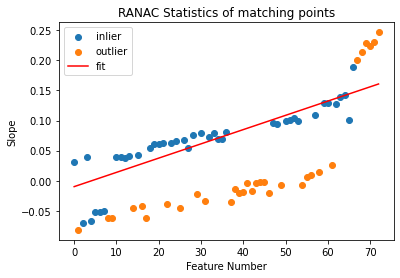

In [98]:
#RANSAC
x = np.linspace(0,len(pns1)-1,len(pns1))
from sklearn.linear_model import RANSACRegressor
x1 = x.reshape(-1,1)
m1 = m.reshape(-1,1)
reg = RANSACRegressor(random_state=0).fit(x1,m1)
inlier_mask = reg.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
reg.score(x1, m1)
t1 = reg.predict(x1)
plt.scatter(x1[inlier_mask],m1[inlier_mask],label='inlier')
plt.scatter(x1[outlier_mask],m1[outlier_mask],label='outlier')
plt.plot(x1,t1,c='red',label='fit')
plt.legend()
plt.title('RANAC Statistics of matching points')
plt.xlabel('Feature Number')
plt.ylabel('Slope')
#plt.savefig('slopes_ransac.png',dpi=1000)
plt.show()
plt.close()

In [99]:
# Remove outliers
good_new=[]
pts1_new = []
pts2_new = []
for i in range(len(pns2)):
    if(inlier_mask[i] == True):
        good_new.append(good[i])
        pts1_new.append(pts1[i])
        pts2_new.append(pts2[i])
        
good = good_new
pts1=pts1_new
pts2=pts2_new

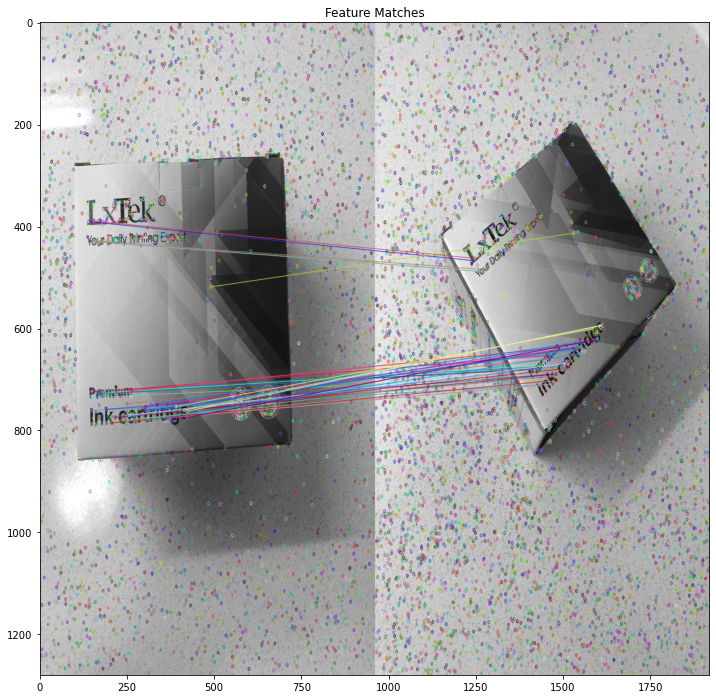

In [100]:
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good[0:40], img2)#,5)# flags=2)
plt.figure(figsize=((12), (12)))
plt.title('Feature Matches')
plt.imshow(img3,aspect='auto')
#plt.savefig('arc_matches_post_ransac.png',dpi=1000)
plt.show()
plt.close()

In [69]:
pns1=np.int32(pts1)
pts2=np.int32(pts2)
pts1 = np.asarray(pts1,dtype=np.float32)
pts2 = np.asarray(pts2,dtype=np.float32)
# Compute fundamental matrix
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
print(F)

[[ 2.21275837e-06 -3.42911586e-06  1.67767909e-03]
 [ 3.35174992e-06  2.63772744e-06 -3.62678374e-03]
 [-3.50240528e-03  7.86100674e-04  1.00000000e+00]]


In [70]:
Fp,_ = cv2.findFundamentalMat(pts1,pts2)
print(Fp)

[[ 4.32891879e-06 -6.84337180e-06  2.26527859e-03]
 [ 7.56989131e-06  5.09835685e-06 -3.55994877e-03]
 [-5.08919931e-03 -2.66189962e-04  1.00000000e+00]]


In [361]:
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

In [103]:
nx=pts1.shape[0] ; ny=pts1.shape[1]-1
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
#print(pts2)
objp[:,1] = 1
objp[:,:2] = np.float32(pts2).T.reshape(-1,2)
y=[]
y.append(objp)
t=[]
t.append(pts1)
print(y[0][0])

[450. 306.   0.]


In [23]:
retval, K, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(y, t, pts1.shape,None,None)

In [4]:
#Camera matrix for iphone X, my phone: Values found online
#f[mm] = 3.99 (possibly 35mm equivalent)
#pixels = 4032x3042
# 1.22 micron = pixel size
K = np.zeros((3,3))
f = 3.99
Wx = 4032
Wy = 3042
Fx = 1000*Wx*f/(Wx*1.22)
Fy = 1000*Wy*f/(Wy*1.22)
K[0,0] = Fx ; K[1,1] = Fy  

In [3]:
#iphone x camera calibration - does checkerboard match the online values?
check_width = 8
check_height = 6
#winSize = 
objp = np.zeros((1, check_width * check_height, 3), np.float32)
objp[0,:,:2] = np.mgrid[0:check_width, 0:check_height].T.reshape(-1, 2)
objpoints = []
imgpoints = []

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
patternSize = (check_width,check_height)
check_imgs = glob.glob('*V2.jpg')

for file in check_imgs:
    image = cv2.imread(file,0)
    ret, corners = cv2.findChessboardCorners(image, patternSize, None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(image, corners, (11,11),(-1,-1), criteria)
        imgpoints.append(corners2)
        image = cv2.drawChessboardCorners(image, patternSize, corners2, ret)
        #plt.imshow(image)
        #plt.show()

In [6]:
# Get camera matrix        
file = check_imgs[0] 
image = cv2.imread(file,0)        
h,w = image.shape[:2]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape, None, None)
K = mtx
#print(K)

In [73]:
#E = K.T * F * K
E =  K.T @ F @ K
print(E)
pts1 = np.asarray(pts1,dtype=np.float32)
pts2 = np.asarray(pts2,dtype=np.float32)
"""
Rrot = np.zeros((3,3))
Rrot,_ = cv2.Rodrigues(rvecs[0])
It=np.zeros((3,4))
It[0,0] = 1 ; It[1,1] = 1 ; It[2,2] = 1 ; It[:,3] = tvecs[0][:,0]
#print(It)
P = K*Rrot
P = np.matmul(P,It)
"""
#E,_ = cv2.findEssentialMat(pts1,pts2,cameraMatrix=K,method=2)
print(E)

[[ 37.25839834 -57.80119888   2.28637302]
 [ 56.49711818  44.50912972  -0.82349261]
 [ -0.76706382   3.16987237  -0.11134783]]
[[ 37.25839834 -57.80119888   2.28637302]
 [ 56.49711818  44.50912972  -0.82349261]
 [ -0.76706382   3.16987237  -0.11134783]]


In [74]:
# Get the error of projection for our results:
#print(objpoints[0])
imgpoints_projected,_ = cv2.projectPoints(objpoints[0],rvecs[0], tvecs[0],K,ret)
#print(imgpoints_projected[0])
#print(imgpoints[0][0])
x = (imgpoints_projected - imgpoints[0]) #/ imgpoints[0]
print('Avg. Reprojection Error [pixels] = ',np.nanmean(x))

Avg. Reprojection Error [pixels] =  0.45628977


In [24]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    pts1=np.array(pts1,dtype=np.int32)
    pts2=np.array(pts2,dtype=np.int32)
    r,c = img1.shape[0],img1.shape[1]
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,10)
        img1 = cv2.circle(img1,tuple(pt1),10,color,10)
        img2 = cv2.circle(img2,tuple(pt2),10,color,10)
    return img1,img2

In [9]:
#print(np.array(y)[0])
print(len(y[0]))
x,_ = cv2.projectPoints(np.array(y),rvecs[0],tvecs[0],K,retval)
print(x[1])
print(y[0][1])
plt.imshow(x[0]);plt.show()

NameError: name 'y' is not defined

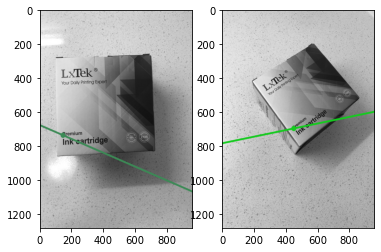

In [109]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)

img1 = cv2.imread('lxtek1.jpg')  #queryimage # left image
img2 = cv2.imread('lxtek2.jpg') #trainimage # right image
#img1, kp1, des1 = compute_orb_keypoints('Arc_de_Triomphe_1.jpg')
#img2, kp2, des2 = compute_orb_keypoints('Arc_de_Triomphe_2.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img5,img6 = drawlines(img1,img2,lines1[0:1,:],pts1[0:1,:],pts2[0:1,:])

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2[0:1,:],pts2[0:1,:],pts1[0:1,:])

plt.subplot(121),plt.imshow(img5,aspect='auto')#,origin='lower')
plt.subplot(122),plt.imshow(img3,aspect='auto')#,origin='lower')
plt.show()

In [83]:
#Triangulation
#  COMPOSE PROJECTION MATRIX OF R, t #
R,_ = cv2.Rodrigues(rvecs[0])
print(R)
print(tvecs)
matrix_1 = np.hstack((R, tvecs[0]))
matrix_2 = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
projMat_1 = np.dot(K, matrix_1)
projMat_2 = np.dot(K, matrix_2)
# TRIANGULATE POINTS #
point_4d_hom = cv2.triangulatePoints(projMat_1[:], projMat_2[:], pts1[:].T, pts2[:].T)
point_4d_hom = point_4d_hom
x=point_4d_hom[3,:]
point_4d_hom = point_4d_hom #/ x[np.newaxis,:]

point_3d = np.zeros((point_4d_hom.shape[1],3))
point_3d[:,0] = point_4d_hom[0,:]
point_3d[:,1] = point_4d_hom[1,:]
point_3d[:,2] = point_4d_hom[3,:]


[[ 0.31669356  0.94848079  0.00945386]
 [-0.94686631  0.3155334   0.06231256]
 [ 0.05611926 -0.02868553  0.99801191]]
(array([[-3.87325689],
       [ 2.69374196],
       [48.26583   ]]), array([[ 2.16782069],
       [-3.53017679],
       [36.22167791]]), array([[-3.54407599],
       [-2.24951113],
       [45.05638392]]))


In [79]:
def calculate_reprojection_error(point_3D, point_2D, K, R, t):
    """Calculates the reprojection error for a 3D point by projecting it back into the image plane"""
    y = R.dot(point_3D.T)
    reprojected_point = K.dot(y + t)
    reprojected_point = cv2.convertPointsFromHomogeneous(reprojected_point.T)[:, 0, :].T
    error = np.linalg.norm(point_2D.reshape((2, 1)) - reprojected_point)
    return error

In [80]:
err = calculate_reprojection_error(point_3d[0,:], pts1[0], K, R, tvecs[2])
print(err)

497.75535548268397


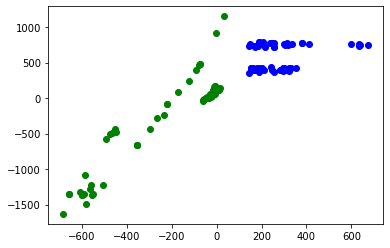

In [81]:
#project the 3d data to a 2d image and see if they line up with raw pts
pts1_proj = np.dot(projMat_1,point_4d_hom).T
#pts1_proj = np.dot(point_4d_hom.T,projMat_2.T)
x=pts1_proj[2,:]
pts1_proj=pts1_proj#/x[np.newaxis,:]
plt.scatter(pts1[:,0],pts1[:,1],color='blue')
plt.scatter(pts1_proj[:,0],pts1_proj[:,1],color='green')

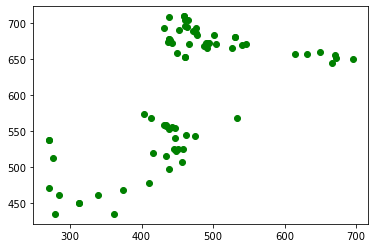

In [ ]:
#project the 3d data to a 2d image and see if they line up with raw pts
pts1_proj = np.dot(projMat_1,point_4d_hom).T
pts2_proj = np.dot(projMat_2,point_4d_hom).T
#pts1_proj = np.dot(point_4d_hom.T,projMat_2.T)
x=pts2_proj[2,:]
pts2_proj=pts2_proj#/x[np.newaxis,:]
#plt.scatter(pts2[:,0],pts2[:,1],color='blue')
#plt.scatter(pts1[:,0],pts1[:,1],color='red')
plt.scatter(-pts2_proj[:,0],-pts2_proj[:,1],color='green')
#plt.scatter(-pts1_proj[:,0],-pts1_proj[:,1],color='purple')

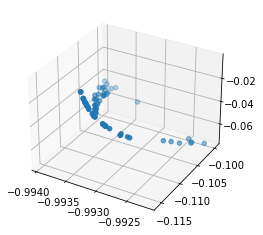

In [19]:
pts1=np.array(pts1,dtype=np.int32)
pts2=np.array(pts2,dtype=np.int32)
img1 = cv2.circle(img1,tuple(pts1[0]),10,(255,0,0),10)
plt.imshow(img1)
plt.close()

point_3d=point_3d#*1000

fig = plt.figure()
ax = plt.axes(projection='3d')
x = point_3d[:, 2]
y = point_3d[:, 1]
z = point_3d[:, 0]
ax.scatter3D(x,y,z)
plt.show()
plt.close()